In [52]:
import docplex.mp.model as md
import matplotlib.patches as pch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from scipy.optimize import curve_fit
import pandas as pd
import mpl_toolkits.axisartist as AA
import seaborn as sns
import scipy.stats as stats
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Times New Roman']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
font1 = {'family': 'SimSun', 'weight': 'normal'}
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 模型建立

In [53]:
greentime = np.array([0.5, 0.4, 0.5, 0.4])
g = greentime
d = np.array([388, 270, 455])
r = 1 - greentime
num = greentime.shape[0]
lower,upper=6.5,13
linspace = np.arange(lower,upper, 0.5)
lin_num = len(linspace)
be=8
M=1000
tau=np.array([5]*num)/140

# 定义变量

In [54]:
model = md.Model("varible_speed")

z = model.continuous_var(lb=1 / 150, ub=1 / 80, name="c")
model.add_constraint(z==1/140)
o_list = [(i) for i in range(num)]
o = model.continuous_var_dict(o_list, lb=0, ub=1, name="o")

# bound_list = [(i, j) for i in range(2) for j in range(lin_num)]
# bound = model.continuous_var_dict(bound_list,lb=0,ub=1)

y_list=[(i,j) for i in range(2) for j in range(lin_num)]
y=model.binary_var_dict(y_list,name="y")

n_L_list = [(i, j) for i in range(2) for j in range(num)]
nL = model.integer_var_dict(n_L_list, lb=-1, ub=10, name="n_L")

nt_list = [(i, j, k) for i in range(2) for j in range(num) for k in range(lin_num)]
nt = model.integer_var_dict(nt_list, lb=-1, ub=10, name="nt")

t_list = [(i, j) for i in range(2) for j in range(num-1)]
t = model.continuous_var_dict(t_list, name="t")

k = 1

# 添加约束

## 定位点函数

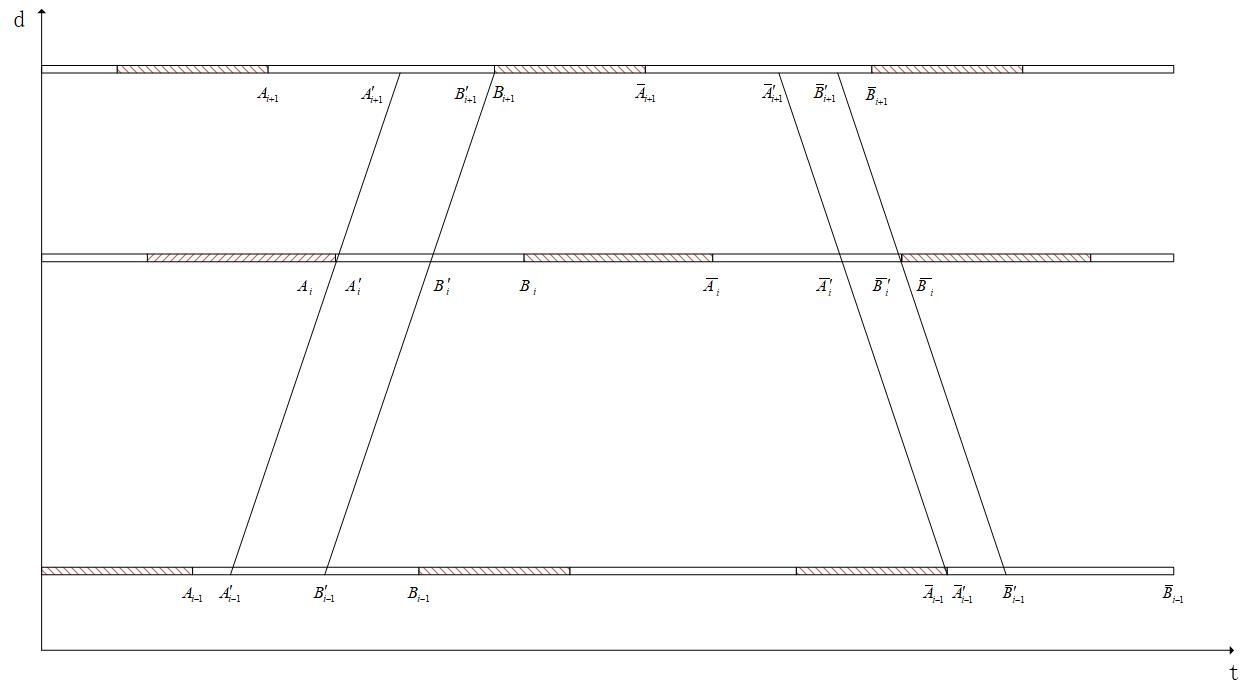

如图所示的绿波时距图中，协调带宽与各交叉口的绿灯相位相交于$A(\bar{A})$、$B(\bar{B})$、$C(\bar{C})$、$D(\bar{D})$、$E(\bar{E})$、$F(\bar{F})$等点，即只要知道这些点在交叉口时距图中的位置，即可推算出该速度下的协调带宽，各点的说明如下：<br>

- $A_i$ ：表示上行带宽所处红灯结束（绿灯开始时间）点位
  
-  $B_i$: 表示上行带宽所处绿灯结束（红灯开始时间）点位
  
- $A_{i}^{\prime}$:上行带宽与交叉口相位的左侧交点
  
- $B_{i}^{\prime}$:上行带宽与交叉口相位的右侧交点
  
- $\bar{A}_{i}$：表示下行带宽所处红灯结束（绿灯开始时间）点位
  
- $\bar{B}_{i}$: 表示下行带宽所处绿灯结束（红灯开始时间）点位
  
- $\bar{A}_{i}^{\prime}$:下行带宽与交叉口相位的左侧交点
  
- $\bar{B}_{i}^{\prime}$:下行带宽与交叉口相位的右侧交点

各点计算公式：<br>
$$
\begin{cases}
A_{i}=o_i+r_i\\
B_{i}=o_i+r_i+g_i\\
A_i^{\prime}=max\{A^{\prime}_{i-1}+t_{i-1},A_i+\tau_i+n_{i}\}\\
B_{i}^{\prime}=min\{B^{\prime}_{i-1}+t_{i-1},B_i+n_{i}\}\\
\bar{A}_{i}=o_i+\bar{r}_i+\Delta_i\\
\bar{B}_{i}=o_i+\bar{r}_i+\bar{g}_i+\Delta_i\\
\bar{A}_{i}^{\prime}=max\{\bar{A}_{i+1}^{\prime}+\bar{t}_{i},\bar{A}_{i}+\bar{\tau}_{i}+\bar{n}_{i}\}\\
\bar{B}_{i}^{\prime}=min\{\bar{B}_{i+1}^{\prime}+\bar{t}_{i},\bar{B}_{i}+\bar{n}_{i}\}
\end{cases}
$$

为了保证带宽式中为正，应确保点$B^{\prime}_i(\bar{B}^{\prime}_i)$始终处于点$A^{\prime}_i(\bar{A}^{\prime})$的右侧，约束表示为：
$$
\begin{cases}
-M*(1-y_v)\leq B^{\prime}_i-A^{\prime}_i\leq M*(1-y_v)\\
-M*(1-y_v)\leq \bar{B}^{\prime}_i-\bar{A}^{\prime}_i\leq M*(1-\bar{y}_v)\\
0\leq B^{\prime}_i-A^{\prime}_i<=g_i\\
0\leq \bar{B}^{\prime}_i-\bar{A}^{\prime}_i<=\bar{g}_i
\end{cases}
$$

上下行带宽计算公式：
$$
\begin{cases}
onbound=B_{n}^{\prime}-A_{n}^{\prime}\\
inbound=\bar{B}_{n}^{\prime}-\bar{A}_{n}^{\prime}
\end{cases}
$$

In [55]:
def onbound(lo_A, lo_B, o, r, g, t, n, start, end,y,onb):
    if start < end:
        lo_A = model.max([lo_A + t[start - 1], o[start] + r[start] + n[start]+tau[start]])
        lo_B = model.min([lo_B + t[start - 1], o[start] + r[start] + g[start] + n[start]])
        model.add_constraint(lo_A <= lo_B+M*(1-y))
        model.add_constraint(lo_B - lo_A <= g[start]+M*(1-y))
        onb.append([lo_A,lo_B])
        return onbound(lo_A, lo_B, o, r, g, t, n, start + 1, end,y,onb)
    else:
        model.add_constraint(be*z-M*(1-y)<=lo_B-lo_A)
        return lo_B - lo_A,onb


def inbound(lo_A, lo_B, o, r, g, t, n, start, end,y):
    if start > end:
        lo_A = model.max([lo_A + t[start], o[start] + r[start] + n[start]+tau[start]])
        lo_B = model.min([lo_B + t[start], o[start] + r[start] + g[start] + n[start]])
        model.add_constraint(lo_A <= lo_B+M*(1-y))
        model.add_constraint(lo_B - lo_A <= g[start]+M*(1-y))
        return inbound(lo_A, lo_B, o, r, g, t, n, start - 1, end,y)
    else:
        model.add_constraint(be*z-M*(1-y)<=lo_B-lo_A)
        return lo_B - lo_A

In [56]:
sum_on,_ = onbound(
    o[0] + r[0],
    o[0] + r[0] + g[0],
    o,
    r,
    g,
    [t[0, i] for i in range(num-1)],
    [nL[0, i] for i in range(num)],
    1,
    num,
    1,
    []
)
sum_in = inbound(
    o[num-1] + r[num-1],
    o[num-1] + r[num-1] + g[num-1],
    o,
    r,
    g,
    [t[1, i] for i in range(num-1)],
    [nL[1, i] for i in range(num)],
    num-2,
    -1,
    1
)

model.add_constraint(o[0] == 0)

docplex.mp.LinearConstraint[](o_0,EQ,0)

## 速度区间变量说明

- $d_i$ ：交叉口$i$与交叉口$i+1$之间的距离

- $e_i,f_i(\bar{e}_i,\bar{f}_i)$: 上行（下行）方向带宽的速度下限和上限
  
- $g_i,h_i(\bar{g}_i,\bar{h}_i)$:上行（下行）方向带宽的速度变化的下限和上限


In [57]:
v_f = upper
v_e = lower
v_h = -2
v_g = 2

速度变化区间为：
$$
\begin{cases}
\frac{d_i}{f_i}z\leq t_i \leq \frac{d_i}{e_i}z\\
\frac{\bar{d}_i}{\bar{f}_i}z \leq \bar{t}_i \leq \frac{\bar{d}_i}{\bar{e}_i}z\\
\frac{d_i}{h_i}z\leq \frac{d_i}{d_{i+1}}t_{i+1}-t_i \leq \frac{d_i}{g_i}z\\
\frac{\bar{d}_i}{\bar{h}_i}z \leq \frac{\bar{d}_i}{\bar{d}_{i+1}}\bar{t}_{i+1}-\bar{t}_i\leq \frac{\bar{d}_i}{\bar{g_i}}z
\end{cases}
$$


In [58]:
for i in range(2):
    for j in range(num - 1):
        model.add_constraint(d[j] / v_f * z <= t[i, j])
        model.add_constraint(t[i, j] <= d[j] / v_e * z)

for i in range(2):
    for j in range(num - 2):
        model.add_constraint(d[j] / v_h * z <= d[j] / d[j + 1] * t[i, j + 1] - t[i, j])
        model.add_constraint(d[j] / d[j + 1] * t[i, j + 1] - t[i, j] <= d[j] / v_g * z)

## 速度分布求解

车辆速度在速度区间$[7.3,14.2]$内呈$X~N(9,1)$的正态分布，分布表示如下：
$$
f(x)=\frac{1}{\sqrt{2\pi}}e^{-\frac{(x-9)^2}{2}}
$$
$$
f(x)=\frac{1}{\sigma\sqrt{2*\pi}}e^{-\frac{x-\mu}{2\sigma^2}}
$$

In [59]:
def getprop(linspace1,linspace2,mu,sigma):
    t1=stats.norm(mu,sigma).cdf(linspace1)
    t2=stats.norm(mu,sigma).cdf(linspace2)
    return t2-t1

In [60]:
mu=9
sigma=np.sqrt(2)
print(linspace)
ProDistribution=getprop(linspace-0.25,linspace+0.25,mu,sigma)
np.around(ProDistribution,2)

[ 6.5  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5]


array([0.03, 0.05, 0.08, 0.11, 0.13, 0.14, 0.13, 0.11, 0.08, 0.05, 0.03,
       0.02, 0.01])

In [61]:
ProDistribution.cumsum()

array([0.02989092, 0.08204751, 0.1624646 , 0.27202658, 0.40392693,
       0.54424314, 0.67614349, 0.78570548, 0.86612257, 0.91827915,
       0.94817007, 0.9633069 , 0.97008007])

In [62]:
linspace

array([ 6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5,
       12. , 12.5])

## 不同速度下的带宽

因不同的速度会导致交叉口之间的行程时间不同，进而导致带宽不同。<br>传统的 MAXBAND 模型只针对某一个速度求解最大带宽，然而这种求解方法可能会导致按照其他速度行驶的车辆无法享受到带宽，甚至会造成更大的停车等待时间。<br>利用定位点函数可顺利求出不同速度下的上行与下行带宽，将带宽引入目标函数，即可求得使各速度最大的相位差。

$$
\begin{cases}
B_{n,v}^{\prime}=min\{B_{n-1,v}^{\prime}+d_{n-1}/v*z,B_{n,v}+n_{n,v}\}\\
A_{n,v}^{\prime}=max\{A_{n-1,v}^{\prime}+d_{n-1}/v*z,A_{n,v}+n_{n,v}\}\\
\bar{B}_{n,v}^{\prime}=min\{\bar{B}_{n-1,v}^{\prime}-d_{n-1}/v*z+\bar{n}_{n-1,v},\bar{B}_{n,v}\}\\
\bar{A}_{n,v}^{\prime}=max\{\bar{A}_{n-1,v}^{\prime}-d_{n-1}/v*z+\bar{n}_{n-1,v},\bar{A}_{n,v}\}
\end{cases}
\quad v\in \Omega
\\
\begin{cases}
onbound_v=B_{n,v}^{\prime}-A_{n,v}^{\prime}\\
inbound_v=\bar{B}_{n,v}^{\prime}-\bar{A}_{n,v}^{\prime}
\end{cases}
$$


为避免某些速度下无法取得有效带宽，进而影响其他速度下的带宽，可尽量
$$
y_{i,k}=\begin{cases}
1,&\text{如果在速度$i$下能够获得有效带宽}\\
0,& \text{其他}
\end{cases}
\\
\begin{cases}
be-M(1-y_{v})\leq onbound_v \leq y_v\\
be-M(1-\bar{y}_v)\leq inbound_v \leq \bar{y}_v
\end{cases}
$$

In [63]:
sum = 0
onb=[]
for index1, v1 in enumerate(linspace):
    on_bound_v,tmp = onbound(
        o[0] + r[0],
        o[0] + r[0] + g[0],
        o,
        r,
        g,
        [d[i] / v1 * z for i in range(num - 1)],
        [nt[0, i, index1] for i in range(num)],
        1,
        num,
        y[0,index1],
        [[o[0] + r[0],o[0] + r[0] + g[0]]]
    )
    onb.append(tmp)
    in_bound_v= inbound(
        o[num-1] + r[num-1],
        o[num-1] + r[num-1] + g[num-1],
        o,
        r,
        g,
        [d[i] / v1 * z for i in range(num - 1)],
        [nt[1, i, index1] for i in range(num)],
        num-2,
        -1,
        y[1,index1]
    )
    # model.add_constraint(on_bound_v == bound[0, index])
    # model.add_constraint(in_bound_v == bound[1, index])
    # sum += (on_bound_v *y[0,index1] + in_bound_v*y[1,len(linspace)-1-index1])*ProDistribution[index1]
    sum += (on_bound_v *y[0,index1]+in_bound_v*y[1,index1] )*ProDistribution[index1]

## 上行方向与下行方向带宽比例

$$
(1-k)\bar{b}\geq (1-k)kb
$$

In [64]:
model.add_constraint((1 - k) * sum_in >= (1 - k) * k * sum_on)

docplex.mp.LinearConstraint[](0,GE,0)

# 目标函数构建

根据

In [65]:
solve_sum =2*(k * sum_in + sum_on)
solve_sum += sum
model.maximize(solve_sum)

# 模型求解


In [66]:
solution = model.solve()

In [67]:
solution.objective_value

1.399378784416689

In [68]:
solution.solve_details

docplex.mp.SolveDetails(time=113.937,status='integer optimal, tolerance')

In [69]:
o = solution.get_value_dict(o)

In [70]:
o

{0: 0, 1: 0.47644557823132927, 2: 0.5052631578947371, 3: 0.9696428571428939}

In [71]:
for oo in o:
    print(o[oo]*140)

0
66.7023809523861
70.7368421052632
135.75000000000514


In [72]:
nt = solution.get_value_dict(nt)
nL = solution.get_value_dict(nL)

In [73]:
z = solution.get_value(z)

In [74]:
1/z

140.0

In [75]:
t = solution.get_value_dict(t)

In [76]:
t

{(0, 0): 0.3569115095430888,
 (0, 1): 0.14835164835164832,
 (0, 2): 0.34484563055991635,
 (1, 0): 0.34638519375361465,
 (1, 1): 0.14835164835164832,
 (1, 2): 0.4713345864661287}

In [77]:
solution.get_value(sum_in)/z

40.1963080778922

In [78]:
solution.get_value(sum_on)/z

34.26523038364634

In [79]:
solution.get_value(in_bound_v),solution.get_value(on_bound_v)

(0.0699285714289597, 0.030642857142820334)

In [80]:
# bound=solution.get_value_dict(bound)
# bound=np.array([[bound[0,j] for j in range(lin_num)],[bound[1,j] for j in range(lin_num)]])
# bound_x=bound.copy()

In [81]:
y=solution.get_value_dict(y)

In [82]:
y

{(0, 0): 1.0,
 (0, 1): 1.0,
 (0, 2): 1.0,
 (0, 3): 1.0,
 (0, 4): 1.0,
 (0, 5): 1.0,
 (0, 6): 1.0,
 (0, 7): 1.0,
 (0, 8): 1.0,
 (0, 9): 1.0,
 (0, 10): 1.0,
 (0, 11): 1.0,
 (0, 12): 0,
 (1, 0): 1.0,
 (1, 1): 1.0,
 (1, 2): 1.0,
 (1, 3): 1.0,
 (1, 4): 1.0,
 (1, 5): 1.0,
 (1, 6): 1.0,
 (1, 7): 1.0,
 (1, 8): 1.0,
 (1, 9): 1.0,
 (1, 10): 1.0,
 (1, 11): 1.0,
 (1, 12): 1.0}

In [83]:
onb[0]

[[docplex.mp.LinearExpr(o_0+0.500), docplex.mp.LinearExpr(o_0+1)],
 [docplex.mp.MaxExpr(59.692c+o_0+0.500,o_1+nt_0_1_0+0.636),
  docplex.mp.MinExpr(59.692c+o_0+1,o_1+nt_0_1_0+1)],
 [docplex.mp.MaxExpr(41.538c+_max216,o_2+nt_0_2_0+0.536),
  docplex.mp.MinExpr(41.538c+_min213,o_2+nt_0_2_0+1)],
 [docplex.mp.MaxExpr(70c+_max226,o_3+nt_0_3_0+0.636),
  docplex.mp.MinExpr(70c+_min223,o_3+nt_0_3_0+1)]]

In [84]:
onbound1=[]
for i in range(lin_num):
    tmp=[]
    for k in range(num):
        tmp.append([solution.get_value(onb[i][k][0]),solution.get_value(onb[i][k][1])])
    onbound1.append(tmp)
onbound1=np.array(onbound1)

In [85]:
onbound1[:,:,1]-onbound1[:,:,0]

array([[0.5       , 0.31421376, 0.0964    , 0.0607797 ],
       [0.5       , 0.2837585 , 0.11759309, 0.11759309],
       [0.5       , 0.25736395, 0.13596044, 0.13596044],
       [0.5       , 0.23426871, 0.15203187, 0.15203187],
       [0.5       , 0.21389056, 0.16621254, 0.16621254],
       [0.5       , 0.19577664, 0.17881758, 0.17881758],
       [0.5       , 0.17956946, 0.17956946, 0.17956946],
       [0.5       , 0.16498299, 0.16498299, 0.16498299],
       [0.5       , 0.15178571, 0.15178571, 0.15178571],
       [0.5       , 0.13978819, 0.13978819, 0.11737013],
       [0.5       , 0.12883392, 0.12883392, 0.0859472 ],
       [0.5       , 0.11879252, 0.11879252, 0.05714286],
       [0.5       , 0.10955442, 0.10955442, 0.03064286]])

# 图形绘制

In [86]:
on_left = list()
on_right = list()
in_left = list()
in_right = list()
def onbound_list(lo_A, lo_B, o, r, g, t, n, start, end):
    if start < end:
        lo_A = max([lo_A + t[start - 1], o[start] + r[start] + n[start]+tau[start]])
        lo_B = min([lo_B + t[start - 1], o[start] + r[start] + g[start] + n[start]])
        return onbound_list(lo_A, lo_B, o, r, g, t, n, start + 1, end)
    else:
        if lo_B-lo_A<be*z:
            return -1,-1
        return lo_A,lo_B

    
def inbound_list(lo_A, lo_B, o, r, g, t, n, start, end):
    if start > end:
        lo_A = max([lo_A + t[start], o[start] + r[start] + n[start]+tau[start]])
        lo_B = min([lo_B + t[start], o[start] + r[start] + g[start] + n[start]])
        return inbound_list(lo_A, lo_B, o, r, g, t, n, start - 1, end)
    else:
        if lo_B-lo_A<be*z:
            return -1,-1
        return lo_A,lo_B


for index1, v1 in enumerate(linspace):
    a,b=onbound_list(
            o[0] + r[0],
            o[0] + r[0] + g[0],
            o,
            r,
            g,
            [d[i] / v1 * z for i in range(num - 1)],
            [nt[0, i, index1] for i in range(num)],
            1,
            num,
        )
    on_left.append(a)
    on_right.append(b)
    a,b=inbound_list(
            o[num-1] + r[num-1],
            o[num-1] + r[num-1] + g[num-1],
            o,
            r,
            g,
            [d[i] / v1 * z for i in range(num - 1)],
            [nt[1, i, index1] for i in range(num)],
            num-2,
            -1,
        )
    in_left.append(a)
    in_right.append(b)
on_left_best,on_right_best=onbound_list(
    o[0] + r[0],
    o[0] + r[0] + g[0],
    o,
    r,
    g,
    [t[0, j] for j in range(num-1)],
    [nL[0, i] for i in range(num)],
    1,
    num,
)

in_left_best,in_right_best=inbound_list(
    o[num-1] + r[num-1],
    o[num-1] + r[num-1] + g[num-1],
    o,
    r,
    g,
    [t[1, j] for j in range(num-1)],
    [nL[1, i] for i in range(num)],
    num-2,
    -1,
)
bound=[]
bound.append(np.array(on_right)-np.array(on_left))
bound.append(np.array(in_right)-np.array(in_left))
bound=np.array(bound)
bound_x=bound.copy()


In [87]:
(bound_x.mean(axis=0)[np.where(bound_x.mean(axis=0)>be*z)[-1]]*ProDistribution[np.where(bound_x.mean(axis=0)>be*z)[-1]]).sum()

0.16642214924009574

In [88]:
linspace[np.where(bound_x.mean(axis=0)>be*z)[-1]]

array([ 6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5])

In [89]:
ProDistribution[(np.where(linspace==7)[0][0]):(np.where(linspace==11.5)[0][0])+1].cumsum()

array([0.05215659, 0.13257367, 0.24213566, 0.37403601, 0.51435222,
       0.64625257, 0.75581456, 0.83623165, 0.88838823, 0.91827915])

In [90]:
(bound_x.mean(axis=0)[bound_x.mean(axis=0)>=be*z]*140).round(0)

array([12., 19., 22., 24., 26., 28., 29., 27., 24., 19., 15.])

In [91]:
((bound_x.mean(axis=0)*140)[(bound_x.mean(axis=0)>=be*z)]*ProDistribution[(bound_x.mean(axis=0)>be*z)]).sum()

23.299100893613407

In [92]:
((bound_x.mean(axis=0))[(bound_x.mean(axis=0)>=be*z)]*ProDistribution[(bound_x.mean(axis=0)>be*z)]).sum()

0.16642214924009574

In [93]:
def func(x,mu,sigma,N):
    return np.exp(-(x-mu)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))*N

In [94]:
propt,propv=curve_fit(func,linspace,bound_x.mean(axis=0),bounds=[0,[15.,3.,1000]],maxfev=100000)
propt

array([9.06290907, 1.98068361, 1.03423157])

0 10 0 12


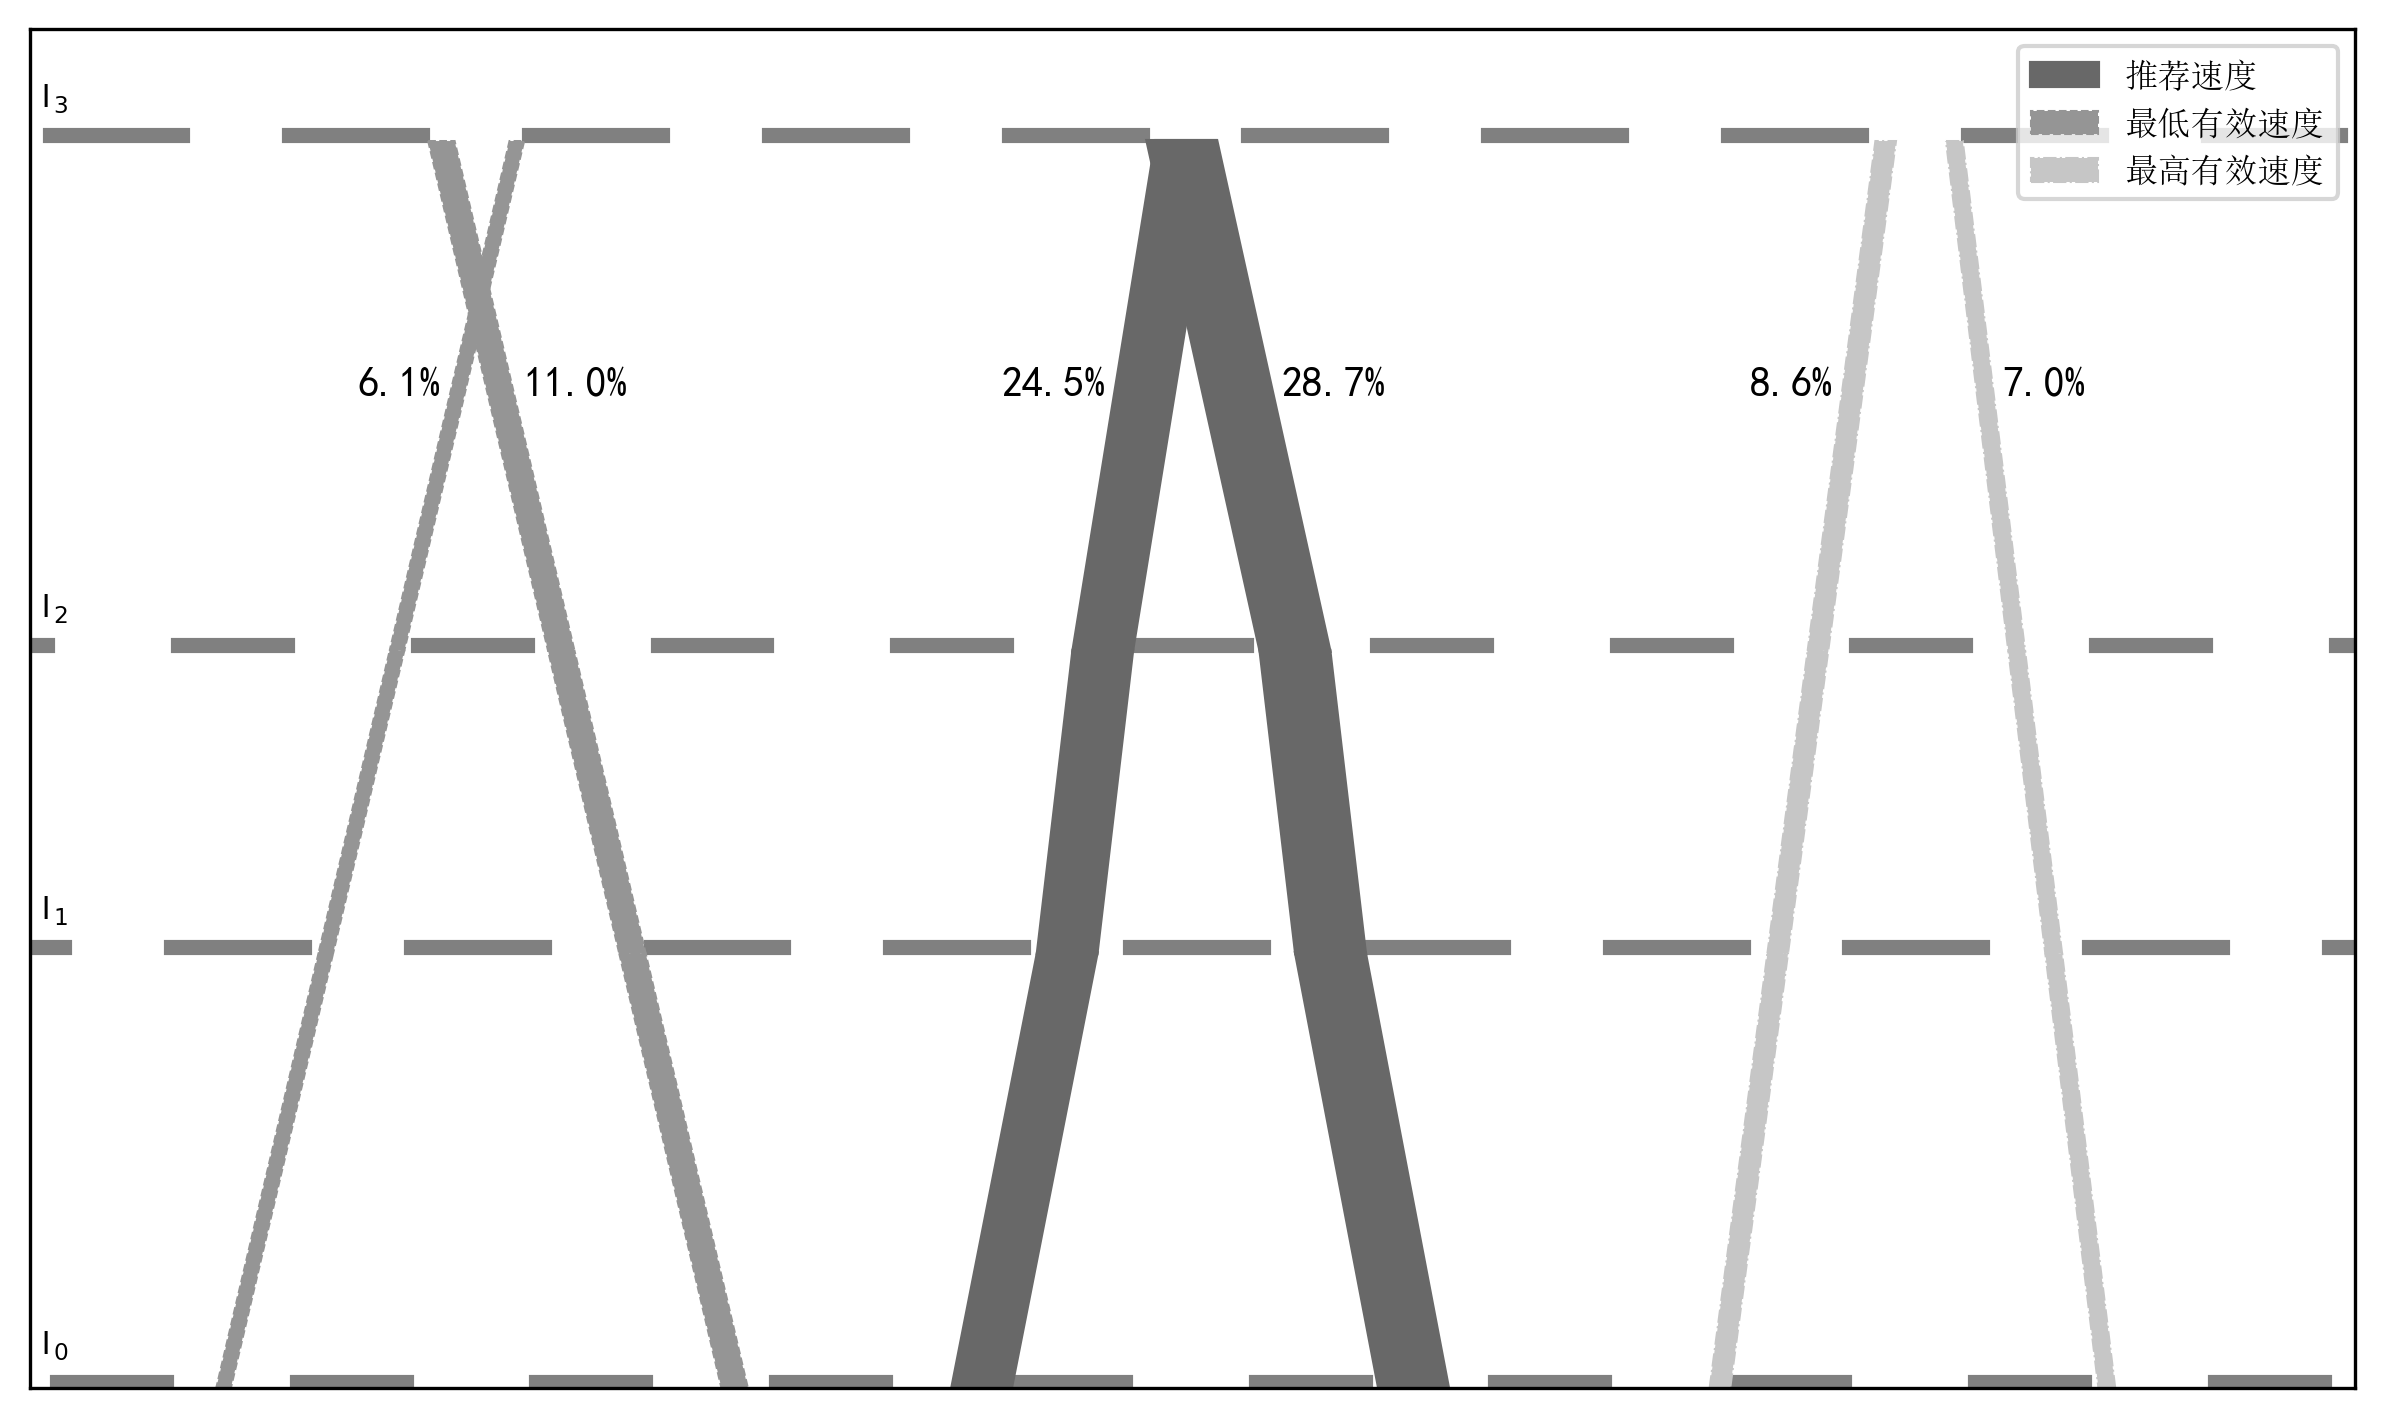

In [95]:
class draw:
    def __init__(self, data,path):
        self.data = dict()
        self.data["GreenTime"] = np.array([])
        self.data["Distance"] = np.array([])
        self.data["RedTime"] = np.array([])
        self.data["Offset"] = np.array([])
        self.data["TravelTime"] = np.array([])
        self.data["OnLeft"] = np.array([])
        self.data["OnRight"] = np.array([])
        self.data["InLeft"] = np.array([])
        self.data["InRight"] = np.array([])
        self.data["Cycle"] = 0
        self.max_width = 0
        self.max_height = 0
        self.min_width = 0
        self.data["linestyle"]=dict()
        self.data["legend"]=dict()
        
        for key in data.keys():
            self.data[key] = data[key]

        if self.data["GreenTime"].ndim != 2:
            self.data["GreenTime"] = np.vstack(
                (self.data["GreenTime"], self.data["GreenTime"])
            )

        if self.data["RedTime"].ndim != 2:
            self.data["RedTime"] = np.vstack(
                (self.data["RedTime"], self.data["RedTime"])
            )

#         for i in range(self.data["TravelTime"].shape[0]):
#             print(self.data["TravelTime"][i])
#             if self.data["TravelTime"][i].ndim != 2:
#                 self.data["TravelTime"][i] = np.vstack(
#                     (-self.data["TravelTime"][i], self.data["TravelTime"][i])
#                 )

        self.fig = plt.figure(figsize=(10,6), dpi=300)
        self.ax = self.fig.add_subplot()
        self.legends=[]
        self.path=path
    def DataFormattter(self):
        self.max_width = (
            max(
                [
                    self.data["OnLeft"].max(),
                    self.data["OnRight"].max(),
                    self.data["InLeft"].max(),
                    self.data["InRight"].max(),
                ]
            )
            + self.data["Cycle"]
        )
        self.max_height = self.data["Distance"].sum() + 100
        self.min_width = (
            min(
                [
                    self.data["OnLeft"].min(),
                    self.data["OnRight"].min(),
                    self.data["InLeft"].min(),
                    self.data["InRight"].min(),
                ]
            )
            - 2*self.data["Cycle"]
        )
        for i in range(self.data["GreenTime"].shape[1]):

            offset_r = (
                self.data["Offset"][i]
                + np.floor(self.min_width / self.data["Cycle"] - 1) * self.data["Cycle"]
            )
            while offset_r <= self.max_width + self.data["Cycle"]:
                self.ax.add_patch(
                    plt.Rectangle(
                        (offset_r, self.data["Distance"][0:i].sum()),
                        self.data["RedTime"][0, i],
                        10,
                        color="gray",
                    )
                )
               
                #                 self.ax.add_patch(plt.Rectangle((offset_r+self.data["RedTime"][0,i],self.data["Distance"][0:i].sum()),self.data["GreenTime"][0,i],10,color='gray'))
                offset_r += self.data["Cycle"]
            self.ax.text(self.min_width*0.99,self.data["Distance"][0:i].sum()+30,"I$_{"+str(i)+"}$",
                         fontsize=self.data["legend"]["fontsize"])
    def GreenAndRed(self):
        pass

    def DrawOnBound(self, TravelTime, OnLeft, OnRight, Distance, start, end,linestyle,tau,paches=None):

        if start <= end:
            zip_x = [
                OnLeft + TravelTime[end - start],
                OnRight + TravelTime[end - start],
                OnRight,
                OnLeft,
            ]
            zip_y = [
                Distance[0 : num - start - 1].sum(),
                Distance[0 : num - start - 1].sum(),
                Distance[0 : num - start].sum(),
                Distance[0 : num - start].sum(),
            ]
            paches=self.ax.add_patch(
                pch.Polygon(xy=list(zip(zip_x, zip_y)), linewidth=linestyle["linewidth"],
                            linestyle=linestyle["linestyle"],color=linestyle["color"])
            )
            return self.DrawOnBound(
                TravelTime,
                OnLeft + TravelTime[end - start],
                OnRight + TravelTime[end - start],
                self.data["Distance"],
                start + 1,
                end,
                linestyle,
                tau
                ,paches
            )
        else:
            return self.legends.append(paches)

    def DrawInBound(self, TravelTime, OnLeft, OnRight, Distance, start, end,linestyle,tau,paches=None):

        if start < end:
            zip_x = [
                OnLeft - TravelTime[start],
                OnRight - TravelTime[start],
                OnRight,
                OnLeft,
            ]
            zip_y = [
                Distance[0 :start+1].sum(),
                Distance[0 :start+1].sum(),
                Distance[0 :start].sum(),
                Distance[0 :start].sum(),
            ]
            paches=self.ax.add_patch(
                pch.Polygon(xy=list(zip(zip_x, zip_y)), linewidth=linestyle["linewidth"],
                            linestyle=linestyle["linestyle"],color=linestyle["color"])
            )
            return self.DrawInBound(
                TravelTime,
                OnLeft - TravelTime[start],
                OnRight - TravelTime[start],
                self.data["Distance"],
                start + 1,
                end,
                linestyle,
                tau
                ,paches
            )
        else:
            plt.text((OnRight+TravelTime[start-1]/2+5),Distance[:start].sum()-Distance[start-1]/2,
                    str(round(OnRight/1.40-OnLeft/1.40,1))+'%',ha='left')
            return self.legends.append(paches)

    def OnBound(self):
        
        for i in range(self.data["TravelTime"].shape[0]):
            if abs(self.data["OnLeft"][i]-self.data["OnRight"][i])<0.01:
                continue
            start = 1
            end = self.data["TravelTime"].shape[2]
            self.DrawOnBound(
                self.data["TravelTime"][i, 0],
                self.data["OnLeft"][i],
                self.data["OnRight"][i],
                self.data["Distance"],
                start,
                end,
                self.data["linestyle"][i],
                tau
            )
            plt.text((self.data["OnLeft"][i]+self.data["TravelTime"][i, 0][end - start]/2-5),
                        self.data["Distance"][0 : num - start - 1].sum()+self.data["Distance"][num-2]/2,
                    str(round( self.data["OnRight"][i]/1.40-self.data["OnLeft"][i]/1.40,1))+'%',ha='right')

    def InBound(self):
        
        for i in range(self.data["TravelTime"].shape[0]):
            if abs(self.data["InLeft"][i]-self.data["InRight"][i])<0.001:
                continue
            start = 0
            end = self.data["TravelTime"].shape[2]
            self.DrawInBound(
                self.data["TravelTime"][i, 1],
                self.data["InLeft"][i],
                self.data["InRight"][i],
                self.data["Distance"],
                start,
                end,
                self.data["linestyle"][i],
                -tau
            )
            # plt.text((self.data["InRight"][i]+self.data["TravelTime"][i, 1][start]/2),
            #             self.data["Distance"][0 : num - start - 1].sum()+self.data["Distance"][num-2]/2,
            #         str(round( self.data["InRight"][i]/1.40-self.data["InLeft"][i]/1.40,1))+'%',ha='left')

    def show(self):
        self.DataFormattter()
        self.OnBound()
        self.InBound()
        plt.xlim([self.min_width, self.max_width])
        plt.ylim([0, self.max_height])
        self.ax.legend(handles=self.legends,labels=self.data["legend"]["label"],
                       loc=self.data["legend"]["pos"],
                       prop= {'family': 'SimSun', 'weight': 'normal',"size":self.data["legend"]["fontsize"]})
        plt.xticks([])
        plt.yticks([])
        plt.show()

    def save_img(self):
        self.fig.savefig(
           self.path,
            bbox_inches="tight",
        )

        
        
min_on,max_on=np.where((bound[0]!=0))[0][0],np.where((bound[0]!=0))[0][-1]
min_in,max_in=np.where((bound[1]!=0))[0][0],np.where((bound[1]!=0))[0][-1]
print(min_on,max_on,min_in,max_in)
a = draw(
    {
        "GreenTime": greentime / z,
        "Distance": d,
        "RedTime": r / z,
        "Offset": np.array([o[i] / z for i in range(num)]),
        "TravelTime": np.array(
            [
                [[-t[0, j] / z for j in range(num - 1)],[t[1, j] / z for j in range(num - 1)],],
                [[-d[j] / linspace[min_on] for j in range(num - 1)],[d[j] / linspace[min_in] for j in range(num - 1)]],
                [[-d[j] / linspace[max_on] for j in range(num - 1)],[d[j] / linspace[max_in] for j in range(num - 1)]]
            ]
        ),
        "OnLeft": np.array([on_left_best / z,on_left[min_on]/z-3/z,on_left[max_on]/z+3/z]),
        "OnRight": np.array([on_right_best / z,on_right[min_on]/z-3/z,on_right[max_on]/z+3/z]),
        "InLeft": np.array([in_left_best / z,in_left[min_in]/z-3/z,in_left[max_in]/z+3/z]),
        "InRight": np.array([in_right_best / z,in_right[min_in]/z-3/z,in_right[max_in]/z+3/z]),
        "Cycle": 1 / z,
        "linestyle": [
            {"linewidth": 1, "linestyle": "-","color":sns.color_palette('Greys',5)[3],"hatch":''},
            {"linewidth": 0.5, "linestyle": "--","color":sns.color_palette('Greys',5)[2],"hatch":''},
            {"linewidth": 0.5, "linestyle": "-.","color":sns.color_palette('Greys',5)[1],"hatch":''}
        ],
        "legend":{
            "label":["推荐速度","最低有效速度","最高有效速度"],
            "pos":"upper right",
            "fontsize":8
        }
    }, "F:\\workspace\\论文\\variable Speed\\time space"
)
a.show()
a.save_img()

In [96]:
a=pd.DataFrame({"OnLeft": np.array([on_left_best / z,on_left[0]/z-2/z,on_left[-1]/z+2/z]),
        "OnRight": np.array([on_right_best / z,on_right[0]/z-2/z,on_right[-1]/z+2/z]),
        "InLeft": np.array([in_left_best / z,in_left[0]/z-2/z,in_left[-1]/z+2/z]),
        "InRight": np.array([in_right_best / z,in_right[0]/z-2/z,in_right[-1]/z+2/z])})

In [97]:
a.dropna(axis=0,how='any')


,OnLeft,OnRight,InLeft,InRight
0,224.750000,259.01523,355.000000,395.196308
1,-12.759158,-4.25000,110.980769,126.394689
2,140.000000,140.00000,635.000000,644.790000


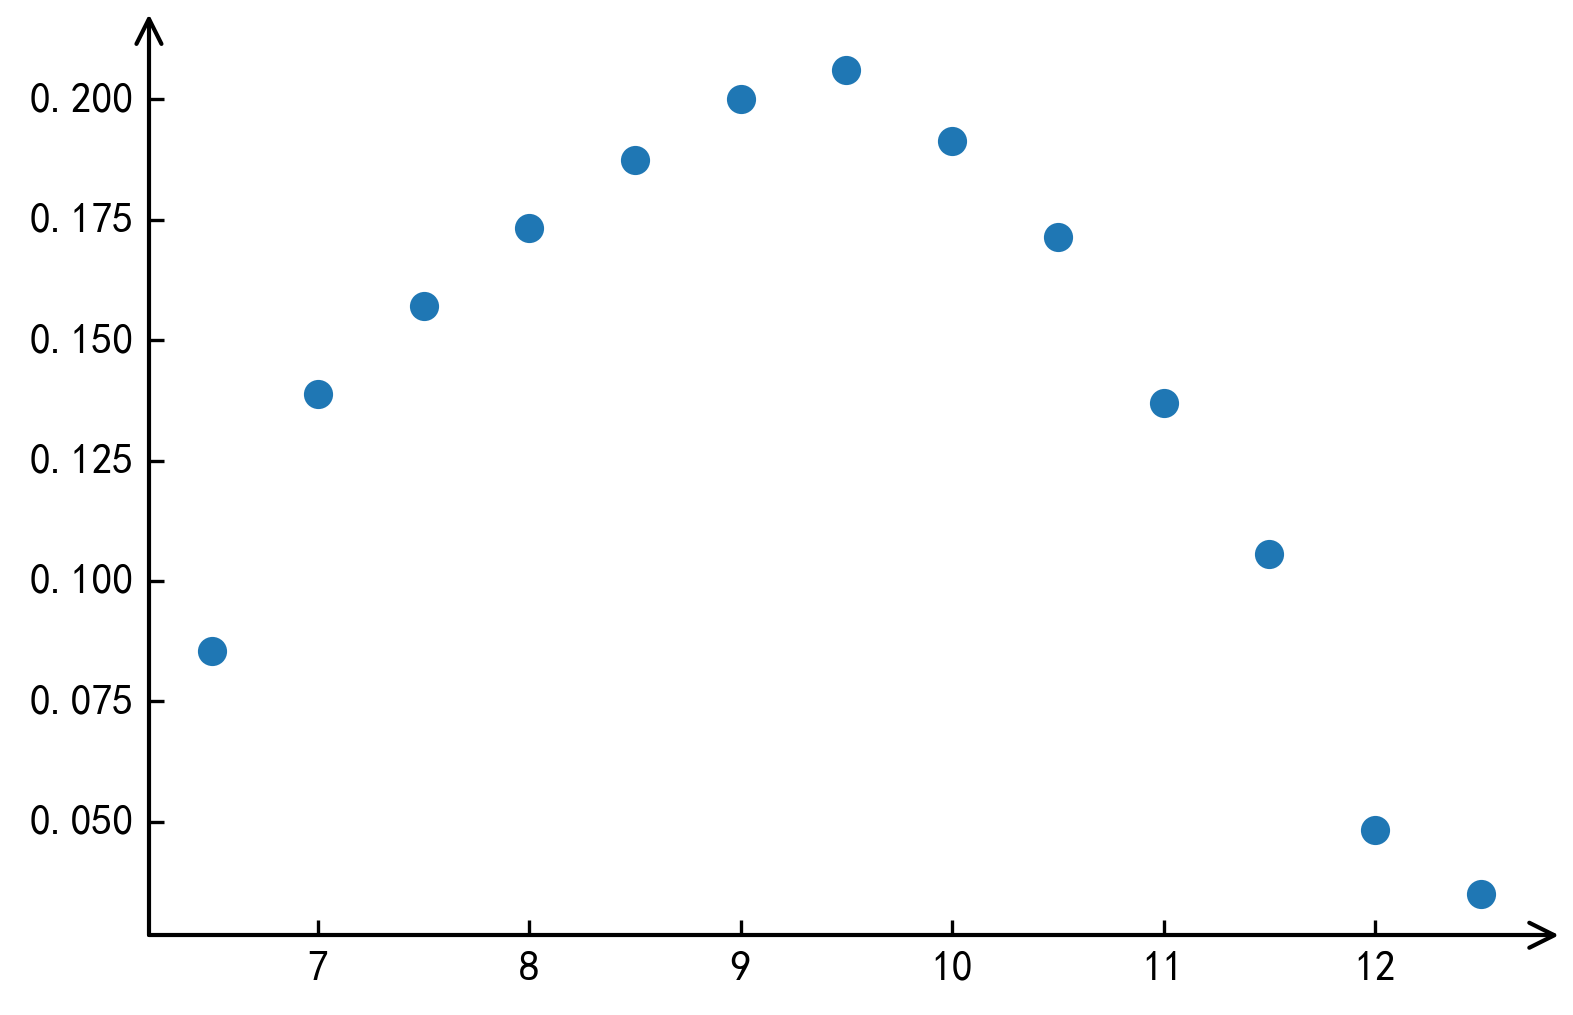

In [98]:
fig1=plt.figure(figsize=(6,4),dpi=300)
ax=AA.Subplot(fig1,111)
fig1.add_axes(ax)
plt.scatter(linspace,bound_x.mean(axis=0))
ax.axis["bottom"].set_axisline_style("->", size = 1.5)
ax.axis["left"].set_axisline_style("->", size = 1.5)
#通过set_visible方法设置绘图区的顶部及右侧坐标轴隐藏
ax.axis["top"].set_visible(False)
ax.axis["right"].set_visible(False)
plt.show()
# fig1.savefig( "F:\\workspace\\论文\\variable Speed\\scatter")

In [99]:
def func(x,mu,sigma,N):
    return np.exp(-(x-mu)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))*N

propt,propv=curve_fit(func,linspace,bound_x.mean(axis=0),bounds=[0,[15.,3.,1000]],maxfev=100000)

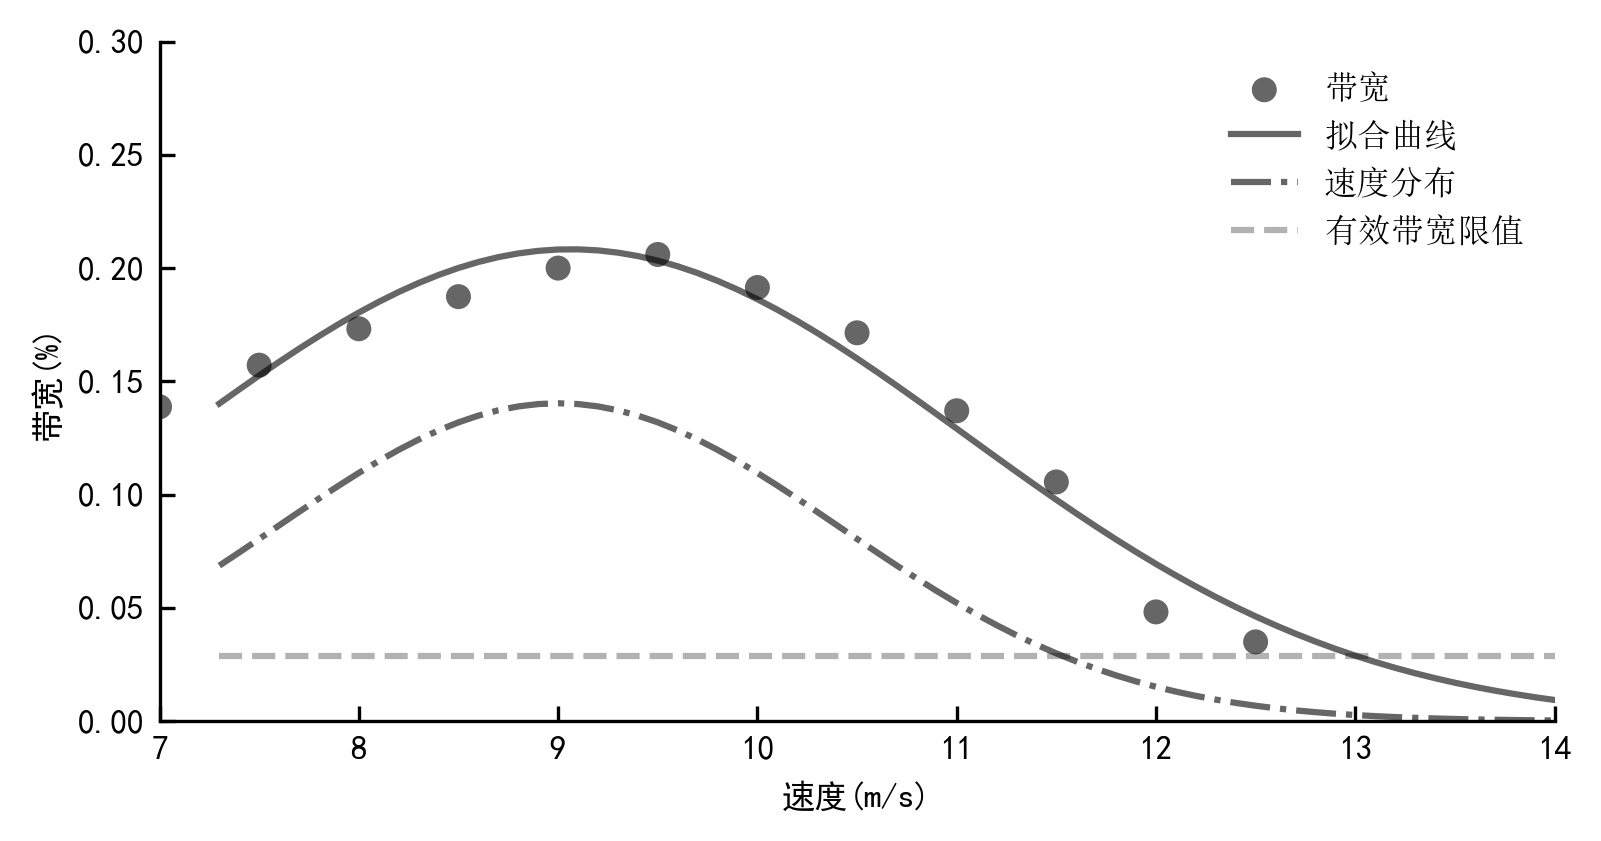

In [100]:
fig1=plt.figure(figsize=(6,3),dpi=300)

font1 = {'family': 'SimSun', 'weight': 'normal',"size":8}

ax=fig1.add_subplot(111)
legends=[]
labels=["带宽","拟合曲线","速度分布","有效带宽限值"]

legend=plt.scatter(linspace,bound_x.mean(axis=0),color='k',alpha=0.6,edgecolor='none')
legends.append(legend)
linspace1=np.arange(7.3,14.2,0.1)
legend,=plt.plot(linspace1,func(linspace1,*propt),color='k',alpha=0.6)
legends.append(legend)

propt1,propv1=curve_fit(func,linspace,ProDistribution,bounds=[0,[15.,3.,1000]],maxfev=100000)
legend,=plt.plot(linspace1,func(linspace1,*propt1),color='k',alpha=0.6,linestyle='-.')
legends.append(legend)

legend,=plt.plot([7.3,14.2],[be/2*z,be/2*z],linestyle="--",alpha=0.3,color='k')
legends.append(legend)

# ax.axis["bottom"].set_axisline_style("->", size = 1.5)
# ax.axis["left"].set_axisline_style("->", size = 1.5)
#通过set_visible方法设置绘图区的顶部及右侧坐标轴隐藏
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel('速度(m/s)',size=8)
ax.set_ylabel('带宽(%)',size=8)
ax.set_ylim([0,0.3])
ax.set_xlim([7,14])
ax.tick_params(axis='y',labelsize=8)
ax.tick_params(axis='x',labelsize=8)

ax.legend(legends,labels,framealpha=0,prop=font1)

# ax.set_title('(a) 干道带宽与速度拟合曲线',fontsize=10,y=-0.255)
plt.show()
# fig1.savefig( "F:\\workspace\\论文\\variable Speed\\scatter-tile",bbox_inches='tight')

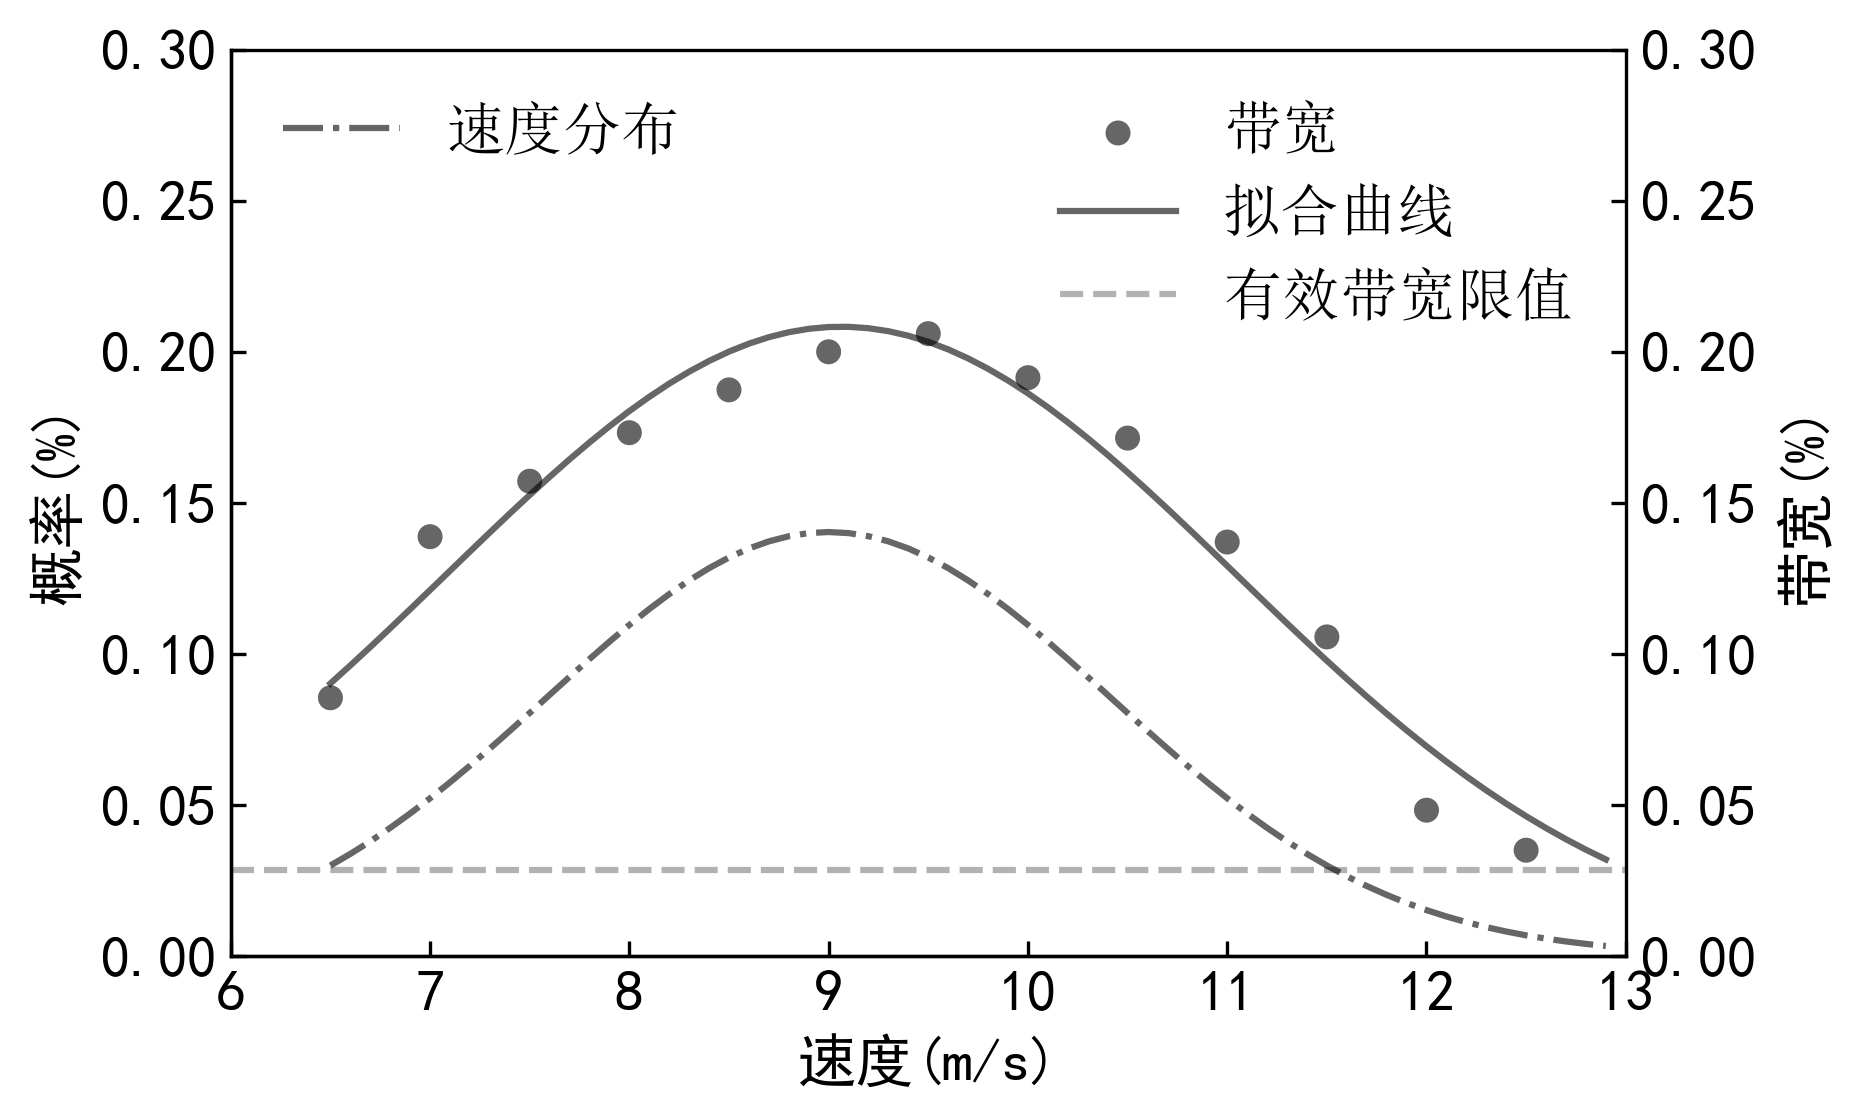

In [101]:
fig1=plt.figure(figsize=(6,4),dpi=300)
fontsize=14

font1 = {'family': 'SimSun', 'weight': 'normal',"size":fontsize}

ax=fig1.add_subplot(111)
legends=[]
legends2=[]
labels=["带宽","拟合曲线","有效带宽限值"]
labels2=["速度分布"]


ax1=ax.twinx()
legend=ax.scatter(linspace,bound_x.mean(axis=0),color='k',alpha=0.6,edgecolor='none')
legends.append(legend)
linspace1=np.arange(lower,upper,0.1)
legend,=ax.plot(linspace1,func(linspace1,*propt),color='k',alpha=0.6)
legends.append(legend)


propt1,propv1=curve_fit(func,linspace,ProDistribution,bounds=[0,[15.,3.,1000]],maxfev=100000)
legend,=ax1.plot(linspace1,func(linspace1,*propt1),color='k',alpha=0.6,linestyle='-.')
legends2.append(legend)
ax.legend(legends2,labels2,loc=2,framealpha=0,prop=font1)
ax.set_ylabel('概率(%)',size=fontsize)
ax.set_xlabel('速度(m/s)',size=fontsize)
ax.tick_params(axis='y',labelsize=fontsize)
ax.set_ylim([0,0.3])

legend,=ax.plot([0,14.2],[be/2*z,be/2*z],linestyle="--",alpha=0.3,color='k')
legends.append(legend)

# ax.axis["bottom"].set_axisline_style("->", size = 1.5)
# ax.axis["left"].set_axisline_style("->", size = 1.5)
#通过set_visible方法设置绘图区的顶部及右侧坐标轴隐藏
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

ax1.set_xlabel('速度(m/s)',size=fontsize)
ax1.set_ylabel('带宽(%)',size=fontsize)
ax1.set_ylim([0,0.3])
ax1.set_xlim([lower-0.5,upper])
ax1.tick_params(axis='y',labelsize=fontsize)
ax.tick_params(axis='x',labelsize=fontsize)

ax1.legend(legends,labels,framealpha=0,prop=font1)

# ax.set_title('(a) 干道带宽与速度拟合曲线',fontsize=10,y=-0.255)
plt.show()
fig1.savefig( "F:\\workspace\\论文\\variable Speed\\scatter-tile",bbox_inches='tight')

In [102]:
be*z

0.05714285714285714